In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ggplot")

In [41]:
numThreads = [1, 2, 4, 8]
colors = ["yo-", "bo-", "ro-", "ko-"]
labels = ["1 worker", "2 workers", "4 workers", "8 workers"]
numLocks = [
      10,    100,   500,    1000,   2500,  5000, 10000,
      20000, 50000, 100000, 150000, 200000
]

insecure = pd.read_csv("insecure.csv")

In [42]:
# An experiment with the same parameters (number of locks, number of threads)
# is repeated multiple times. 
# This function computes the average runtime in nanoseconds over those repititions.
def averages_of_repeated_experiments(data, num_threads):
  averages = []
  for n in numLocks:
    sum = 0
    count = 0
    for i, row in data.iterrows():
      if row["locks"] == n and row["threads"] == num_threads:
        count += 1
        sum += row["nanoseconds"]
    averages.append((sum/count) / 10 ** 9); # average, from nanoseconds to seconds
  return averages


# Plots the runtime in nanoseconds it takes to acquire the given number of locks as a line graph.
def plot_runtime(data):

  fig = plt.figure(figsize=(15, 5))

  ax = fig.add_subplot(111)

  for threads, color, title in zip(numThreads, colors, labels):    
    averages = averages_of_repeated_experiments(data, threads)
    ax.plot(numLocks, averages, color, label=title)

  plt.legend()
  plt.title("Time to acquire an increasing number of locks")
  plt.xlabel("Number of locks acquired")
  plt.ylabel("Runtime in seconds")
  plt.show()


# Plots the throughput of locks per second given the number of locks acquired as a line graph.
def plot_throughput(data):
  fig = plt.figure(figsize=(15, 5))
  ax = fig.add_subplot(111)

  for threads, color, title in zip(numThreads, colors, labels):   
    throughput = []
    averages = averages_of_repeated_experiments(data, threads)
    for locks, duration in zip(numLocks, averages):
      throughput.append(locks / duration)
    ax.plot(numLocks, throughput, color, label=title)

  plt.legend()
  plt.xlabel("Number of locks acquired")
  plt.ylabel("Throughput (Locks per second)")
  plt.title("Throughput relative to number of locks acquired")
  # plt.ylim([0.0000072, 0.0000076])
plt.show()



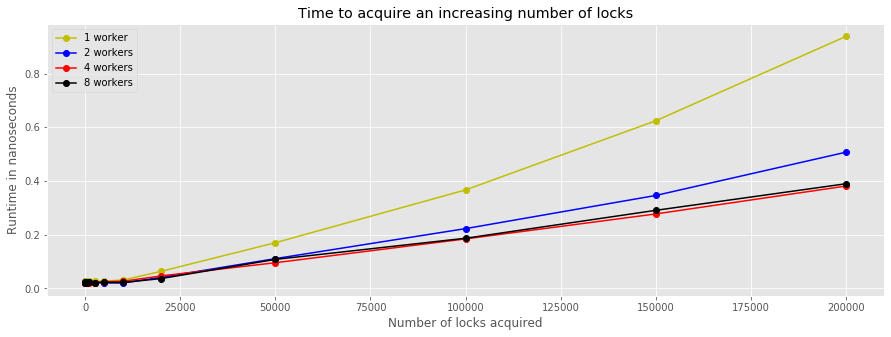

In [43]:
plot_runtime(insecure)

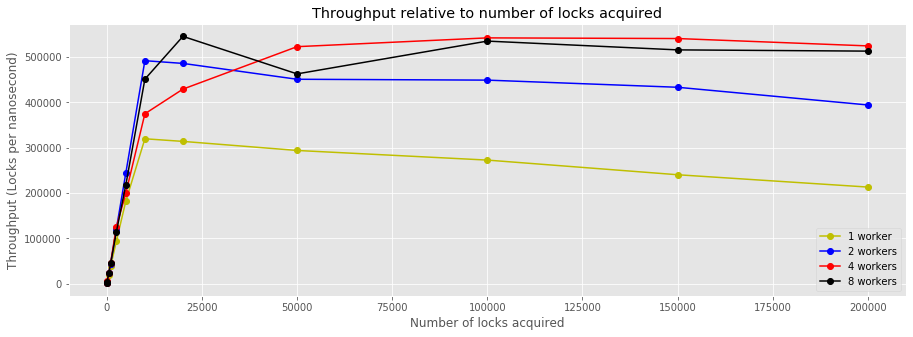

In [44]:
plot_throughput(insecure)